In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import Callback, EarlyStopping

In [36]:
df = pd.read_parquet("cleaned.parquet")
df

,lyric_clean
0,he said the way my blue eyes shined
1,put those georgia stars to shame that night
2,i said that is a lie
3,just a boy in a chevy truck
4,that had a tendency of gettin' stuck
...,...
3150,whose laugh i could recognize anywhere
3151,you and me forevermore
3152,to the memories they will hold on to you
3153,hold on to the memories they will hold on to you


In [37]:
combined_lyrics = ' '.join(df['lyric_clean'])
tokenizer = Tokenizer()
tokenizer.fit_on_texts([combined_lyrics])
total_words = len(tokenizer.word_index) + 1
input_sequences = []
for line in df['lyric_clean']:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)

max_sequence_len = max(len(x) for x in input_sequences)
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))
predictors, label = input_sequences[:,:-1], input_sequences[:,-1]
label = to_categorical(label, num_classes=total_words)

# Splitting Data
X_train, X_val, y_train, y_val = train_test_split(predictors, label, test_size=0.2, random_state=42)

In [38]:
# Perplexity Calculation
class Perplexity(Callback):
    def on_epoch_end(self, epoch, logs={}):
        cross_entropy = logs.get('loss')
        perplexity = np.exp(cross_entropy)
        print(f' - perplexity: {perplexity}')

def viz_metrics(history):
    # Visualizing Training and Validation Metrics
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

def train(model):
  earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=1, mode='auto', restore_best_weights=True)
  history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), callbacks=[earlystop, Perplexity()])
  return history

def generate(model, seed_text):
  next_words = 100  # Number of words you want to generate

  for _ in range(next_words):
      # Tokenize the current seed text
      token_list = tokenizer.texts_to_sequences([seed_text])[0]

      # Pad the sequence
      token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')

      # Predict the next word (as probabilities)
      probabilities = model.predict(token_list, verbose=0)

      # Get the index of the most likely next word
      predicted = np.argmax(probabilities, axis=-1)[0]

      # Convert the predicted token to a word
      output_word = ""
      for word, index in tokenizer.word_index.items():
          if index == predicted:
              output_word = word
              break

      # Update the seed text
      seed_text += " " + output_word

  return seed_text


def sample_with_temperature(probabilities, temperature=1.0):
    # Adjust the probabilities with temperature
    probabilities = np.asarray(probabilities).astype('float64')
    probabilities = np.log(probabilities + 1e-10) / temperature  # Adding a small constant to avoid division by zero
    exp_probs = np.exp(probabilities)
    probabilities = exp_probs / np.sum(exp_probs)

    # Sample the next word based on the adjusted probabilities
    choices = range(len(probabilities))  # This should be the range of your vocabulary
    next_word = np.random.choice(choices, p=probabilities)

    return next_word

def generate_with_temperature(model, seed_text, temperature=1.0):

    next_words = 100
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')

        probabilities = model.predict(token_list, verbose=0)[0]  # Get softmax probabilities

        # Use temperature to adjust the probabilities and sample the next word
        predicted = sample_with_temperature(probabilities, temperature=temperature)  # Adjust the temperature as needed

        # Convert the predicted token to a word and update the seed text
        output_word = ""
        for word, index in tokenizer.word_index.items():
            if index == predicted:
                output_word = word
                break
        seed_text += " " + output_word

    return seed_text


## Baseline model

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 18, 100)           238700    
                                                                 
 lstm_1 (LSTM)               (None, 150)               150600    
                                                                 
 dense_1 (Dense)             (None, 2387)              360437    
                                                                 
Total params: 749737 (2.86 MB)
Trainable params: 749737 (2.86 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
537/537 [==============================] - 14s 23ms/step - loss: 6.0220 - accuracy: 0.0516 - val_loss: 5.8327 - val_accuracy: 0.0545
Epoch 2/50
537/537 [==============================] - 5s 9ms/step - loss: 5.4890 - accuracy: 0.0800 - val_loss: 5.5088 - val_accuracy: 0.1

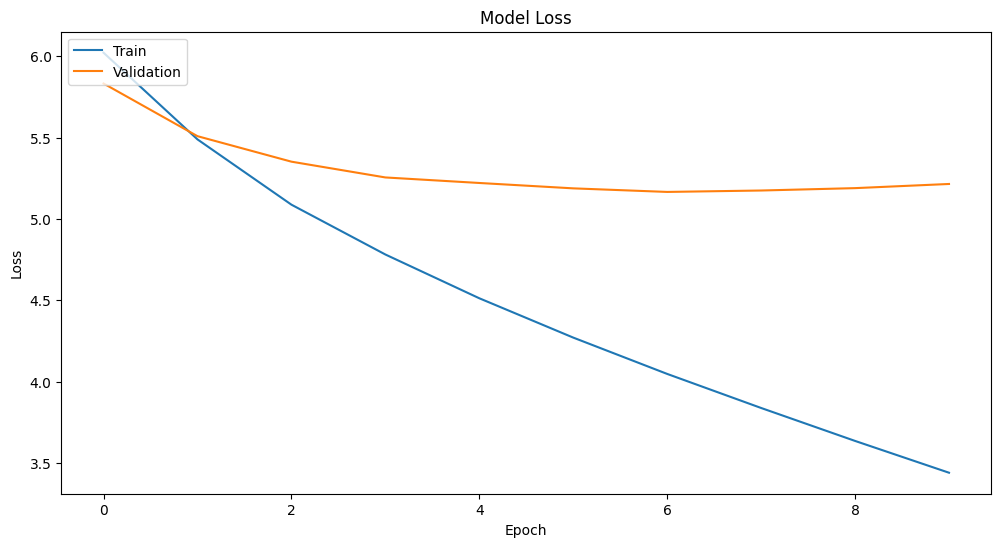

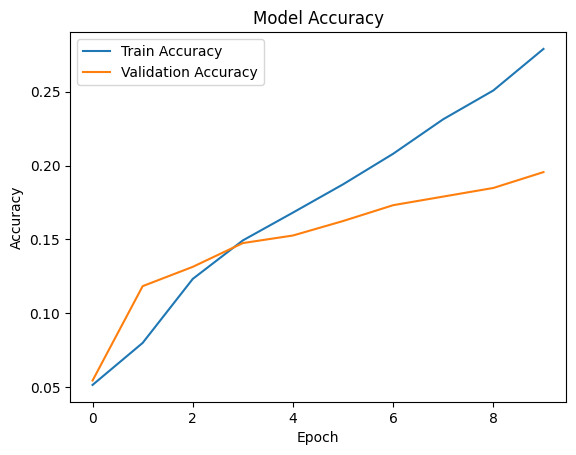

In [11]:
# Building the Model
model = Sequential()
model.add(Embedding(total_words, 100, input_length=max_sequence_len-1))
#model1.add(LSTM(150, return_sequences=True))
model.add(LSTM(150))
model.add(Dense(total_words, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

history = train(model)
viz_metrics(history)



In [12]:
generate(model, 'ring any bells')

"ring any bells late to me like you are the way you are the one girl i am not fragile marvelous to be waiting waiting waiting waiting fragile waiting light fragile sun break break n' ohwho fragile sun ohwho n' ohwho fragile ohwho fragile ohwho fragile ohwho fragile ohwho you ohwho fragile beauty fragile ohwho ahaah haa fragile ohwho fragile ohwho fragile ohwho fragile sun ohwho ahaah car fragile ohwho fragile ohwho fragile ohwho fragile ohwho fragile ohwho fragile ohwho fragile ohwho fragile ohwho fragile ohwho fragile ohwho fragile ohwho fragile ohwho fragile ohwho fragile ohwho fragile ohwho fragile ohwho fragile ohwho fragile"

In [16]:
generate_with_temperature(model, 'ring any bells', 0.6)

"ring any bells reputation beautiful town tied haa uh uh uh uh la uh uh door uh la skirt trend mindedly chevy bills train dear haunt movie onehand clyde exman haah twinsized reputation's wonderin' haha liar and you feast it is better am not all alone as it is been late to me i see you back to me break be through your heart light me play to me to me okay do not me who would would wished pastry watching you wanted that you are so no of this way you think you are the one friend we said say i am"

## Embedding/LTSM/Dropout/LTSM/Dropout/Dense

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 18, 100)           238700    
                                                                 
 lstm_9 (LSTM)               (None, 18, 150)           150600    
                                                                 
 dropout_2 (Dropout)         (None, 18, 150)           0         
                                                                 
 lstm_10 (LSTM)              (None, 100)               100400    
                                                                 
 dropout_3 (Dropout)         (None, 100)               0         
                                                                 
 dense_6 (Dense)             (None, 2387)              241087    
                                                                 
Total params: 730787 (2.79 MB)
Trainable params: 73078

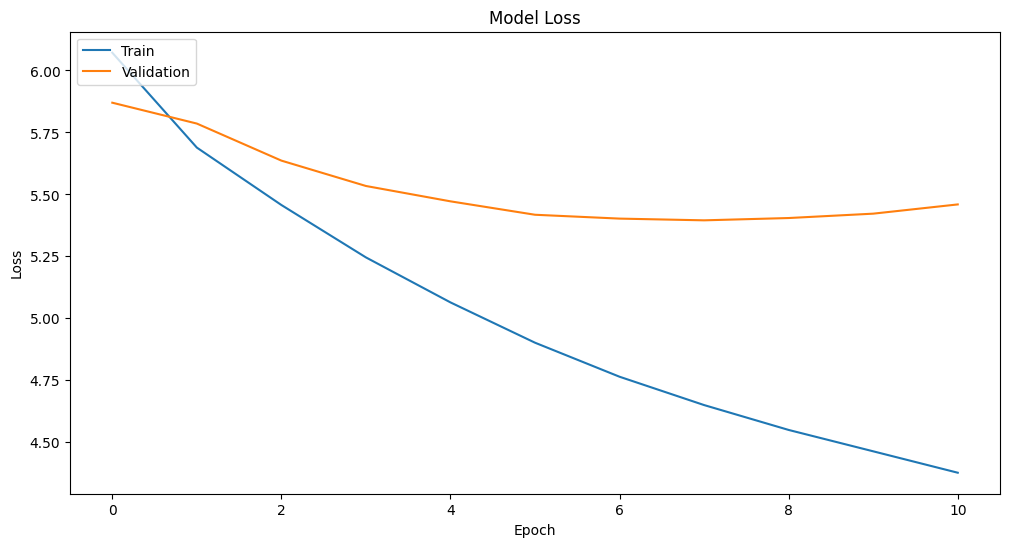

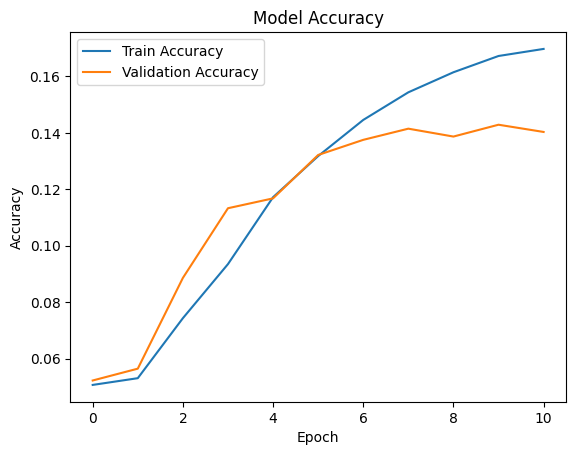

'ice on a hand and i am not in the time i am not in the time i clyde clyde clyde of the time clyde do clyde clyde the time clyde the clyde clyde of the clyde of the time i am not in clyde clyde clyde of clyde clyde clyde clyde clyde clyde clyde exman clyde the time clyde the time clyde clyde the time clyde clyde clyde clyde clyde clyde clyde clyde clyde clyde of clyde clyde of clyde clyde clyde of clyde clyde clyde clyde clyde clyde clyde clyde clyde of the clyde of the clyde clyde of the clyde clyde'

In [ ]:
# Building the Model
model2 = Sequential()
model2.add(Embedding(total_words, 100, input_length=max_sequence_len-1))
model2.add(LSTM(150, return_sequences=True))
model2.add(Dropout(0.1))
model2.add(LSTM(100))
model2.add(Dropout(0.1))
model2.add(Dense(total_words, activation='softmax'))
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model2.summary()

history = train(model2)
viz_metrics(history)

generate(model2, 'ice on a hand')

## Embedding/Bidirectional LTSM/Dropout/Bidirectional LTSM/Dense

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 18, 100)           238700    
                                                                 
 bidirectional (Bidirection  (None, 18, 500)           702000    
 al)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 18, 500)           0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 300)               781200    
 onal)                                                           
                                                                 
 dense_7 (Dense)             (None, 2387)              718487    
                                                                 
Total params: 2440387 (9.31 MB)
Trainable params: 2440

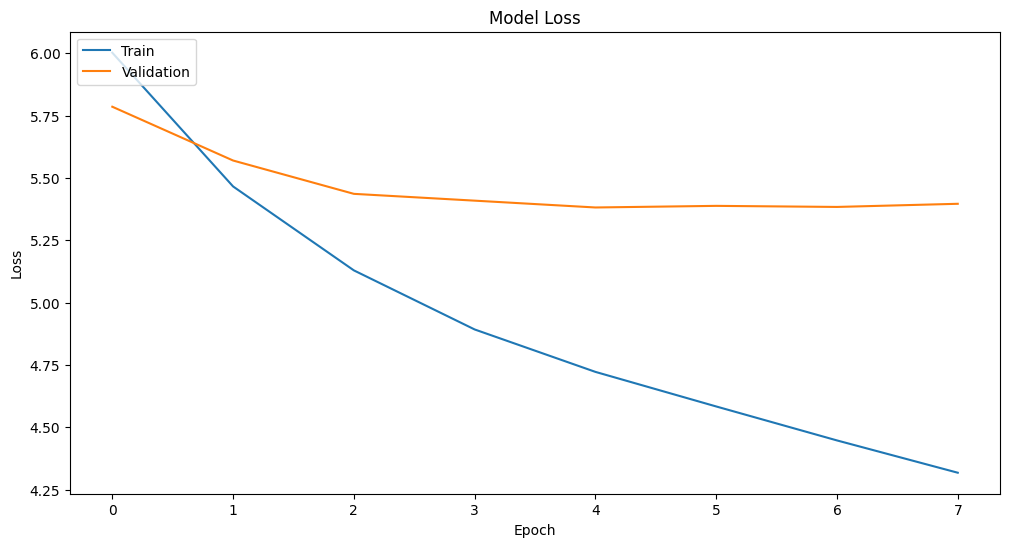

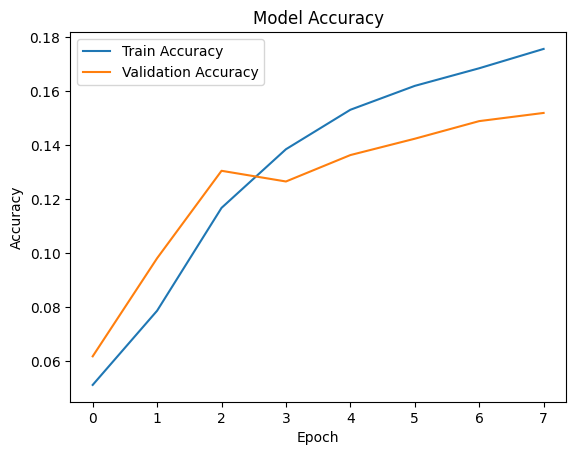

'ice on a hand and i am not like you are not the eyes and you are not not like lovely is the eyes rebel the eyes rebel robber girl robber not like lovely nasty not you are not not not not not not not the girl and sidewalk you are not not not not not not not not not not not not not the eyes rebel robber girl robber not not not not not not not not not not not not not not the girl and sidewalk robber not not not not not not not not not not not not not not the'

In [ ]:
model3 = Sequential()
model3.add(Embedding(total_words, 100, input_length=max_sequence_len-1))
model3.add(Bidirectional(LSTM(250, return_sequences=True)))
model3.add(Dropout(0.2))
model3.add(Bidirectional(LSTM(150)))
model3.add(Dense(total_words, activation='softmax'))
model3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model3.summary()

history = train(model3)
viz_metrics(history)

generate(model3, 'ice on a hand')

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 18, 100)           238700    
                                                                 
 bidirectional_2 (Bidirecti  (None, 500)               702000    
 onal)                                                           
                                                                 
 dense_8 (Dense)             (None, 2387)              1195887   
                                                                 
Total params: 2136587 (8.15 MB)
Trainable params: 2136587 (8.15 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
537/537 [==============================] - 15s 22ms/step - loss: 5.9855 - accuracy: 0.0522 - val_loss: 5.7573 - val_accuracy: 0.0622
Epoch 2/50
537/537 [==============================] - 5s 10ms/step - l

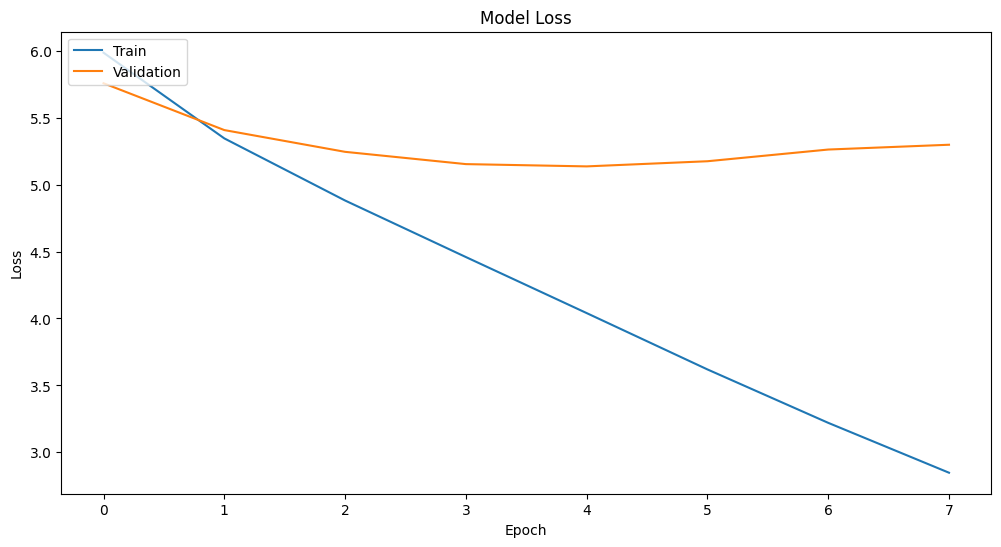

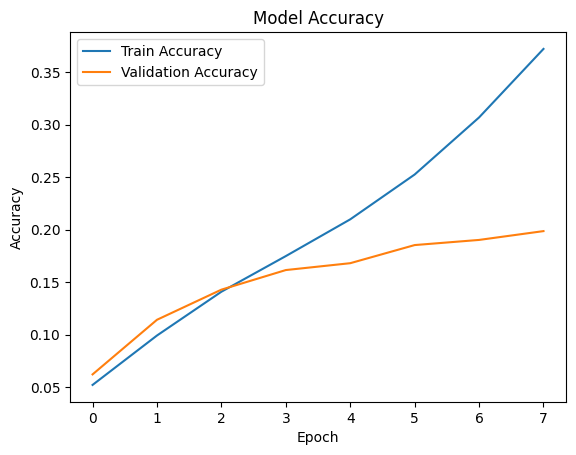

"ice on a hand and i am just up to be her her game time you out the ocean ocean ocean day together is playboy off the first thousand n' n' n' n' n' n' n' n' n' door out the street light me up book book book book book book book book to me to me to me talk to me me to me talk to me me out of the door in the door in the door in the door in the door in the door in the door in the door in the door in the door in the door in"

In [ ]:


model4 = Sequential()
model4.add(Embedding(total_words, 100, input_length=max_sequence_len-1))
model4.add(Bidirectional(LSTM(250)))
#model4.add(Dropout(0.1))
model4.add(Dense(total_words, activation='softmax'))
model4.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model4.summary()

history = train(model4)
viz_metrics(history)

generate(model4, 'ice on a hand')

## Using Pretrained Word Embeddings


In [22]:
import numpy as np

# Load GloVe embeddings
embedding_index = {}
with open('glove.6B.100d.txt', encoding='utf-8') as f:  # Specify the encoding here
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs

# Create an embedding matrix
embedding_matrix = np.zeros((total_words, 100))  # Assuming 100 is the embedding dimension
for word, i in tokenizer.word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None and i < total_words:
        embedding_matrix[i] = embedding_vector


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 18, 100)           238700    
                                                                 
 bidirectional (Bidirection  (None, 500)               702000    
 al)                                                             
                                                                 
 dense_2 (Dense)             (None, 2387)              1195887   
                                                                 
Total params: 2136587 (8.15 MB)
Trainable params: 1897887 (7.24 MB)
Non-trainable params: 238700 (932.42 KB)
_________________________________________________________________
Epoch 1/50
537/537 [==============================] - 10s 10ms/step - loss: 5.7947 - accuracy: 0.0814 - val_loss: 5.3556 - val_accuracy: 0.1259
Epoch 2/50
537/537 [==============================] - 6s 10ms/ste

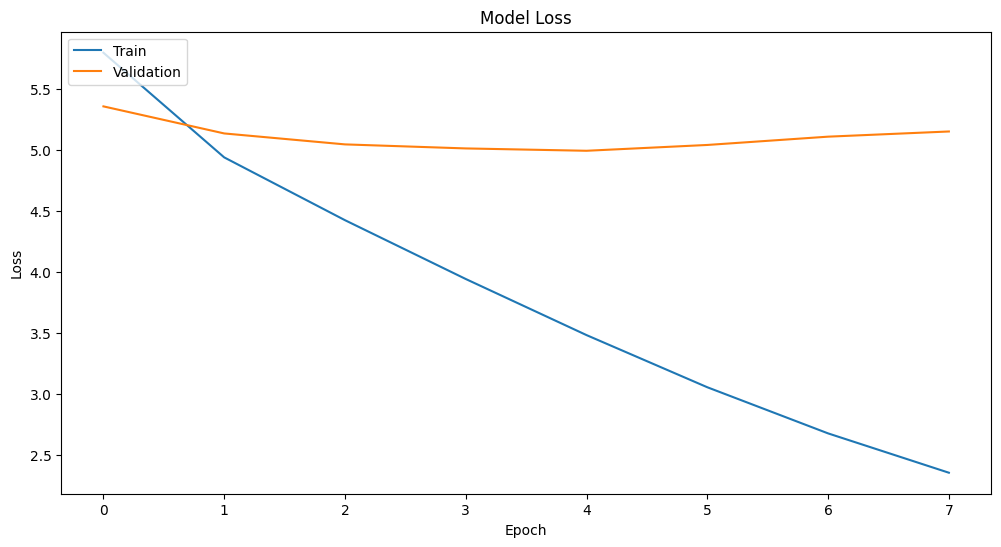

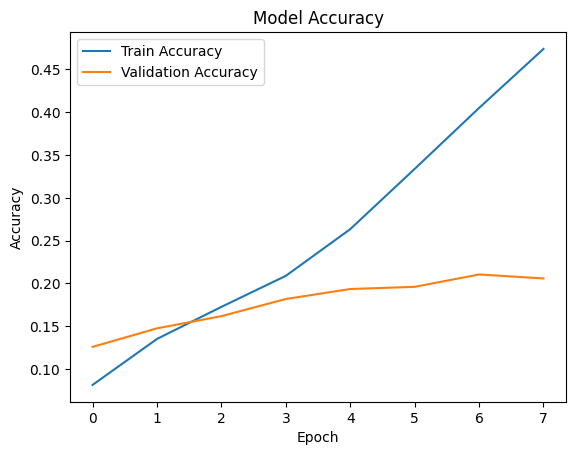

"ice on a hand time dress to you are the first town first up dress n' fake win fingers stakes crime break break break break n' obvious crime fairytale nasty cats light me tame 'till you fella ever grow to me like you cut me for me when you would be here by the best dress you will be the time when you are enough to my first marvelous sing behind lingering need up fake n' fake fake n' n' n' drought trippin' hole hole crooked self mmmm light becomes down traffic washed imagined hahahaeee buzzcut back at me when you made me to"

In [23]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dropout, Dense

model_x = Sequential()
model_x.add(Embedding(total_words, 100, weights=[embedding_matrix], input_length=max_sequence_len-1, trainable=False))
#model_x.add(LSTM(250, return_sequences=True))
#model_x.add(Dropout(0.1))
#model_x.add(LSTM(250))
model_x.add(Bidirectional(LSTM(250)))
#model_x.add(Dropout(0.1))
model_x.add(Dense(total_words, activation='softmax'))
model_x.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model_x.summary()

history = train(model_x)
viz_metrics(history)

generate(model_x, 'ice on a hand')
generate_with_temperature(model, 'ice on a hand', 0.6)
